### some helper functions

In [ ]:
from matplotlib import pyplot as plt
from src.utils.config import load_config
import pickle
from src.data.dataset import Dataset
from src.model.transformer import Transformer
from src.training.evaluator import Evaluator
import torch
import torch.nn as nn
import sys
import os
import numpy as np
import random

cmap='Blues'

# Set random seeds.
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For CUDA reproducibility
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
def analyze_cross_attention(model, examples, start_idx=0, step=3, att_head=2, figsize=(15, 12), cmap='Blues', show_diagonal=False, num_examples=9):
    """
    Analyze and visualize cross-attention for multiple examples in a grid.
    
    Args:
        start_idx (int): Starting index of examples from validation set
        step (int): Generation step to analyze
        att_head (int): Attention head to visualize
        cmap (str): Colormap for the attention heatmap
        show_diagonal (bool): Whether to show the diagonal line
        num_examples (int): Number of examples to show (default 9 for 3x3 grid)
    
    Returns:
        list: List of model outputs for each example
    """
    # Calculate grid dimensions
    grid_size = int(num_examples ** 0.5)
    if grid_size * grid_size < num_examples:
        grid_size += 1
    
    # Create figure with subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    if grid_size == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    all_outputs = []
    
    for i in range(num_examples):
        ex_idx = start_idx + i
        if ex_idx >= len(examples['inputs']):
            break
            
        # Get example data
        inputs = examples['inputs'][ex_idx]
        targets = examples['targets'][ex_idx]
        max_new_tokens = targets.shape[0] - 1
        
        # Generate with attention tracking
        outputs = model.generate_with_attention_tracking(
            src=inputs.unsqueeze(0),
            tgt=targets.unsqueeze(0)[:, :-max_new_tokens],
            max_new_tokens=max_new_tokens,
            temperature=1,
            top_k=1
        )
        all_outputs.append(outputs)
        
        # Check if prediction is correct
        is_correct = (outputs["generated_tokens"][0, -max_new_tokens:] == targets[-max_new_tokens:]).all().item()
        
        # Extract cross-attention for visualization
        crs_att = outputs['attention_history'][step]['decoder'][0]['cross_attention'][0, att_head, :, :].squeeze()
        
        # Plot in subplot
        ax = axes[i]
        im = ax.imshow(crs_att.cpu().numpy(), cmap=cmap, aspect='auto')
        ax.set_xlabel('Input Position')
        ax.set_ylabel('Generated Position')
        
        ax.set_title(f'Ex {ex_idx}', fontsize=10)
        
        # Optional diagonal line
        if show_diagonal:
            height, width = crs_att.shape
            ax.plot([1, width-1], [height-2, 0], 'r--', linewidth=1, alpha=0.8)
    
    # Hide unused subplots
    for i in range(num_examples, len(axes)):
        axes[i].set_visible(False)
    
    # Adjust layout first
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, right=0.90)
    
    # Add shared colorbar with proper positioning
    cbar = fig.colorbar(im, ax=axes[:num_examples], shrink=0.8, aspect=30, pad=0.02)
    cbar.set_label('Attention Score')
    
    # Add main title with proper spacing
    fig.suptitle(f'Cross-Attention Head {att_head} at Step {step} Generation', fontsize=16, y=0.95)
    
    plt.show()
    
    return all_outputs

def analyze_self_attention(model, examples, ex_idx, step, att_head, cmap='Blues', figsize=(5, 5)):
    """
    Analyze and visualize decoder self-attention for a specific example, step and head.
    
    Args:
        ex_idx (int): Index of example from validation set
        step (int): Generation step to analyze
        att_head (int): Attention head to visualize
        cmap (str): Colormap for the attention heatmap
        figsize (tuple): Figure size for the plot
    
    Returns:
        dict: Model outputs including attention history and the self-attention matrix
    """
    # Get example data
    inputs = examples['inputs'][ex_idx]
    targets = examples['targets'][ex_idx]
    max_new_tokens = targets.shape[0] - 1
    
    # Generate with attention tracking
    outputs = model.generate_with_attention_tracking(
        src=inputs.unsqueeze(0),
        tgt=targets.unsqueeze(0)[:, :-max_new_tokens],
        max_new_tokens=max_new_tokens,
        temperature=1,
        top_k=1
    )
    
    # Extract self-attention matrix
    dec_self_att = outputs['attention_history'][step]['decoder'][0]['self_attention'][0, att_head, :, :].squeeze()
    
    # Create visualization
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(dec_self_att.cpu().numpy(), cmap=cmap, aspect='auto')
    ax.set_xlabel('Key Sequence Position')
    ax.set_ylabel('Query Sequence Position')
    
    # Adjust layout first
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, right=0.85)
    
    # Add colorbar with proper positioning
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Attention Score')
    
    # Add title with proper spacing
    fig.suptitle(f'Decoder Self-Attention Head {att_head} at Step {step} Generation (Example {ex_idx})', fontsize=14, y=0.95)
    
    plt.show()
    
    # Add self-attention matrix to outputs for return
    outputs['self_attention_matrix'] = dec_self_att
    return outputs

### analysis

In [7]:
#=================================
# load your model here by specifying the training timestamp 
#---------------------------------
sesh = 'n13_v1'   # change this

#=================================
config_path = f'cache/{sesh}/config'
config = load_config(config_path)

batch_size = config['training']['batch_size']
n = config['data']['n']      
data_path = config['data']['data_path']
try:
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
except Exception as e:
    raise Exception(f"Error loading saved data: {e}.")
dataset = Dataset(data,batch_size=batch_size)

model_args = config['model']
model_args['max_len'] = n*2 + 1  # +1 for BOS token
max_new_tokens = model_args['max_len'] - 1  # Exclude BOS token, so -1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()      

model = Transformer(**model_args)
model_path = f'cache/{sesh}/best_model.pth'
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.to(device)
model.eval()
print(f"Best model loaded from {sesh}.")
evaluator = Evaluator(model, dataset.eval_dataloader, criterion, device)
eval_loss_epoch, eval_accuracy_epoch = evaluator.evaluate(max_new_tokens)
print(f"For validation data: loss = {eval_loss_epoch:.4f}, accuracy = {eval_accuracy_epoch:.8f}")

Best model loaded from n13_v1.
For validation data: loss = 0.0002, accuracy = 0.99520000


In [8]:
# Prepare examples for analysis
n_examples = 100  # Number of examples to analyze
examples = {
    'inputs': dataset.eval_dataloader.dataset[:n_examples][0].to(device),  # First 5 inputs
    'targets': dataset.eval_dataloader.dataset[:n_examples][1].to(device)   # First 5 targets
}

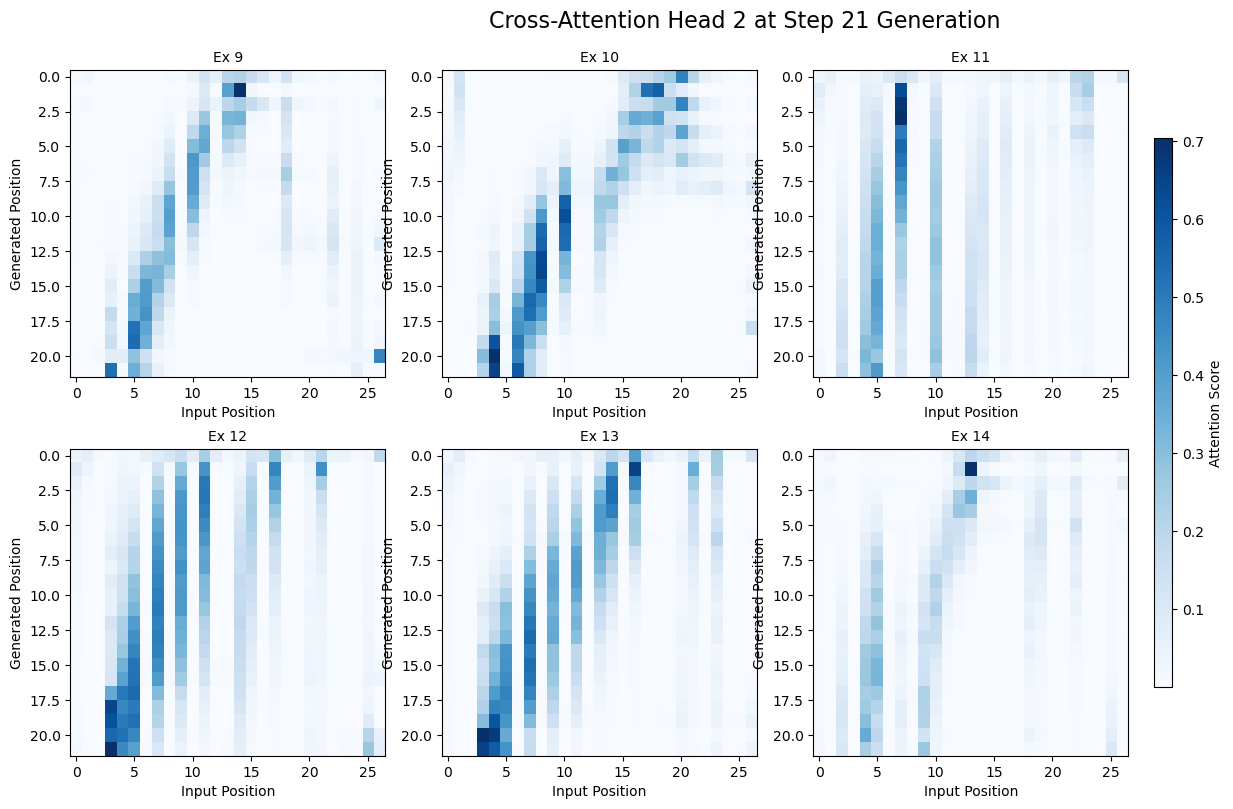

In [9]:
# Example: Analyze 9 examples starting from example #9
# this if for attention head 2 at step 15 (the 16th token generated in the sequence)
#=================
start_idx = 9  # the index of the first example to analyze
num_examples = 6  # Number of examples to show
att_head = 2    # attention head to visualize
step = 21  # 16th token generated in the sequence
#=================
outputs = analyze_cross_attention(model, examples, start_idx=start_idx, step=step, att_head=att_head, num_examples=num_examples)

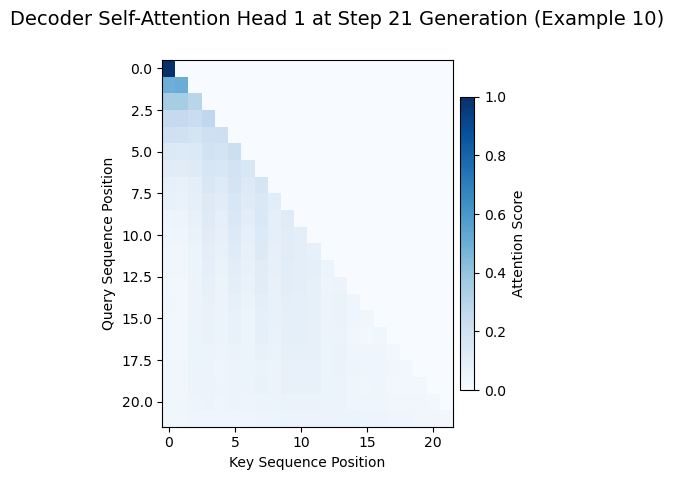

In [10]:
# Example usage:
outputs = analyze_self_attention(model, examples, ex_idx=10, step=21, att_head=1, cmap='Blues')

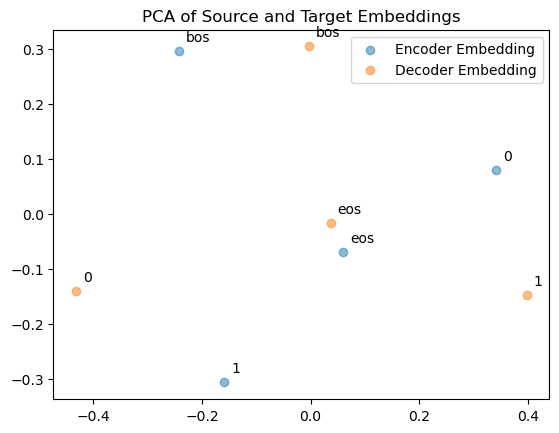

In [ ]:
# run a PCA on the source and target embeddings

emb = model._embedding_weights()
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
src_emb = pca.fit_transform(emb['src_embedding'].detach().cpu().numpy())
tgt_emb = pca.fit_transform(emb['tgt_embedding'].detach().cpu().numpy())
tgt_emb = pca.transform(emb['tgt_embedding'].detach().cpu().numpy())
plt.scatter(src_emb[:, 0], src_emb[:, 1], label='Encoder Embedding', alpha=0.5)
plt.scatter(tgt_emb[:, 0], tgt_emb[:, 1], label='Decoder Embedding', alpha=0.5)
plt.title('PCA of Source and Target Embeddings')
plt.legend()
dict = dataset.dictionary
# give the dots labels
for i, (x, y) in enumerate(tgt_emb):
    plt.annotate(f'{dict[i]}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left', va='bottom')
for i, (x, y) in enumerate(src_emb):
    plt.annotate(f'{dict[i]}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left', va='bottom')